## Visualizing  Spacy + Georesolver  - By Years

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`



### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/results_paper/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.5, top=0.95)
    fig.set_size_inches(20, 30)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned using Spacy and the Georesolver', fontsize = 20)
    else:
        fig.suptitle('15 Places most mentioned but not resolved using Spacy and the Georesolver ', fontsize = 20)
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='green')
            axs[i,0].set_title('Year %s' %y)
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='yellowgreen')
            axs[i,0].set_title('Year %s' %y)
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']), rotation=40)  
        axs[i,0].set_ylabel('Frequency of Places') 
        i=i +1 

In [7]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    tt=df_group_places_years_final.reset_index()
    years=set()
    for pl in list_places:
        freq_term={}
        for i in sorted(list_years):
            try:
                freq_term[i]= list(tt.loc[(tt['Place']==pl) & (tt['level_0']==i) ]["count"])[0]
            except:
                freq_term[i] = 0
        plt.plot(*zip(*sorted(freq_term.items())), lw=line_weight, alpha=alpha, label=pl, marker='d') 
    
    for i in sorted(list_years):
        years.add(i)
    plt.xticks(sorted(list(years)), rotation=50)  
    plt.title('Yearly cumulative plot of selected places' )
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places')
    plt.xlabel("Years")
    plt.show()

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: en_core_web_lg
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [8]:
results=read_query_results('georesolution_en_core_web_lg_total')

In [9]:
df_total= geresolution_dataframe(results)

year 1868
year 1848
year 1828
year 1883
year 1825
year 1901
year 1882
year 1846
year 1842
year 1806
year 1838
year 1803


In [10]:
df_total.head(15)

,Latitude,Longitude,Place,Page,Year
0,53.42133,-6.27008,DUBLIN,Page11,1868
1,55.95,-3.3725,EDINBURGH,Page11,1868
2,42.6286895,-73.9134588,SCOTLAND,Page13,1868
3,51.64875,-0.0974,LONDON,Page13,1868
4,40.7834345,-73.9662495,NEW YORK,Page13,1868
5,55.95,-3.3725,EDINBURGH,Page13,1868
6,55.95,-3.3725,EDINBURGH,Page14,1868
7,37.0831162,-94.3771668,Scotland,Page15,1868
8,55.75,-2.5,Berwickshire,Page15,1868
9,36.933119,-94.0946568,Berwick,Page15,1868


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [11]:
df_total[["Place"]].count()

Place    170549
dtype: int64

### Explorations with georesolved places

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [12]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [13]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [14]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

**Important: Number of Places that has been identified but not resolved!**

In [15]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude     0
Longitude    0
Place        0
Page         0
Year         0
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [16]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     170549
Longitude    170549
Place        170549
Page         170549
Year         170549
dtype: int64

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [17]:
df_resolved = df_total[df_total['Latitude'] != '']

In [18]:
df_resolved.count()

Latitude     170549
Longitude    170549
Place        170549
Page         170549
Year         170549
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [19]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [20]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,53.42133,-6.27008,Dublin,Page11,1868
1,55.95,-3.3725,Edinburgh,Page11,1868
2,42.6286895,-73.9134588,Scotland,Page13,1868
3,51.64875,-0.0974,London,Page13,1868
4,40.7834345,-73.9662495,New york,Page13,1868
5,55.95,-3.3725,Edinburgh,Page13,1868
6,55.95,-3.3725,Edinburgh,Page14,1868
7,37.0831162,-94.3771668,Scotland,Page15,1868
8,55.75,-2.5,Berwickshire,Page15,1868
9,36.933119,-94.0946568,Berwick,Page15,1868


**Important: Calculating the number of georesolved places by year**

Here is when I realised that we had empty geolocations for some editions. 

In [21]:
df_capitalized.groupby("Year").count()

,Latitude,Longitude,Place,Page
Year,,,,
1803,6638,6638,6638,6638
1828,1512,1512,1512,1512
1846,12978,12978,12978,12978
1868,47170,47170,47170,47170
1882,22593,22593,22593,22593
1883,19646,19646,19646,19646
1901,60012,60012,60012,60012


### Visualizing the 15 places more mentioned (and resolved) per year

In [22]:
mpl.rcParams['figure.dpi']=300
years_list = df_capitalized['Year'].unique()
filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude','Year']].groupby(['Latitude', 'Longitude','Year'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    place_label, place_freq = label_freq_places(df_filter_year, df_max_geolocations, filter_list)
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

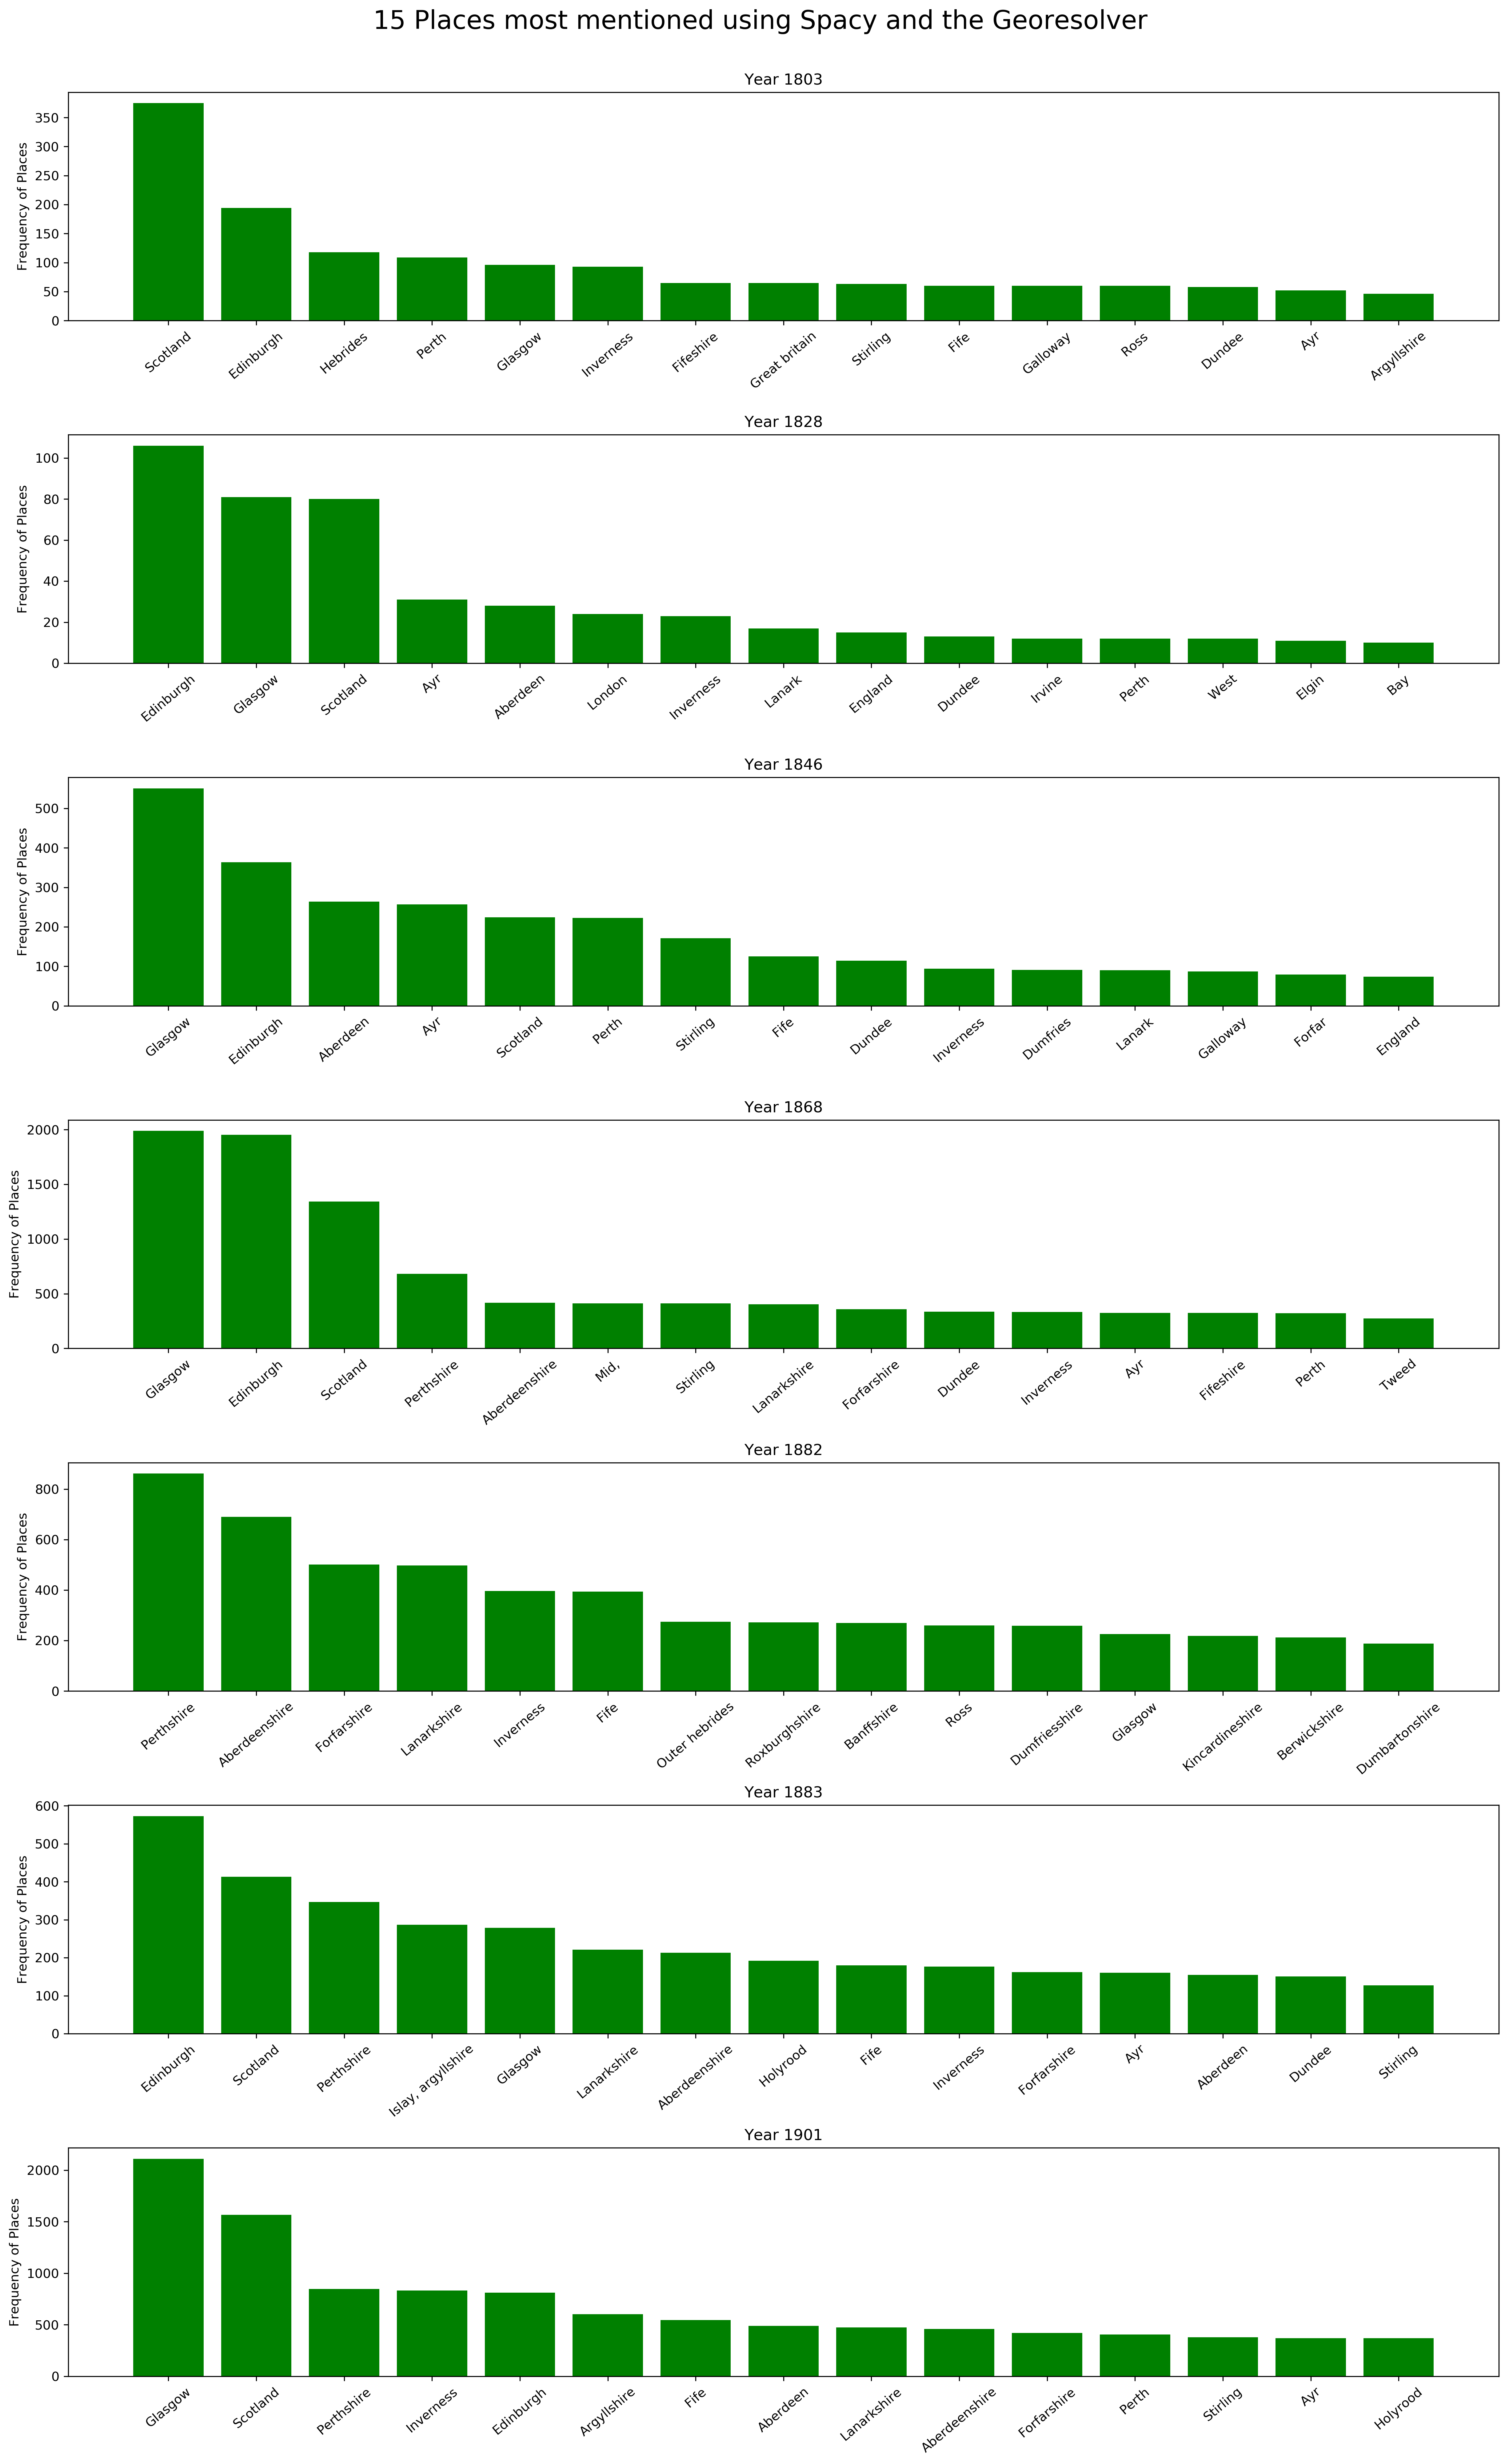

In [23]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

In [24]:
# Exploring the 15 places more georeolved for a particular year - e.g1828. 
df_group_places_years["1828"]

,Place,count
4,Edinburgh,106
7,Glasgow,81
13,Scotland,80
1,Ayr,31
0,Aberdeen,28
11,London,24
8,Inverness,23
10,Lanark,17
6,England,15
3,Dundee,13


### Cumulative Yearly Plot 

First we have to create a new concatenated dataframe with all the information per year - Years as the index 

In [25]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [26]:
df_group_places_years_final.head(15)

Place  count
1803 13       Scotland    375
     3       Edinburgh    194
     9        Hebrides    118
     11          Perth    109
     7         Glasgow     96
     10      Inverness     93
     5       Fifeshire     65
     8   Great britain     65
     14       Stirling     63
     4            Fife     60
     6        Galloway     60
     12           Ross     60
     2          Dundee     58
     1             Ayr     52
     0     Argyllshire     46

Just an example how to explore the number of times that Edinburgh has been georesolved over the years

In [27]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']['count']


1803  3     194
1828  4     106
1846  4     364
1868  3    1954
1883  4     573
1901  4     811
Name: count, dtype: int64

In [28]:
df_group_places_years_final.Place.unique()

array(['Scotland', 'Edinburgh', 'Hebrides', 'Perth', 'Glasgow',
       'Inverness', 'Fifeshire', 'Great britain', 'Stirling', 'Fife',
       'Galloway', 'Ross', 'Dundee', 'Ayr', 'Argyllshire', 'Aberdeen',
       'London', 'Lanark', 'England', 'Irvine', 'West', 'Elgin', 'Bay',
       'Dumfries', 'Forfar', 'Perthshire', 'Aberdeenshire', 'Mid,',
       'Lanarkshire', 'Forfarshire', 'Tweed', 'Outer hebrides',
       'Roxburghshire', 'Banffshire', 'Dumfriesshire', 'Kincardineshire',
       'Berwickshire', 'Dumbartonshire', 'Islay, argyllshire', 'Holyrood'], dtype=object)

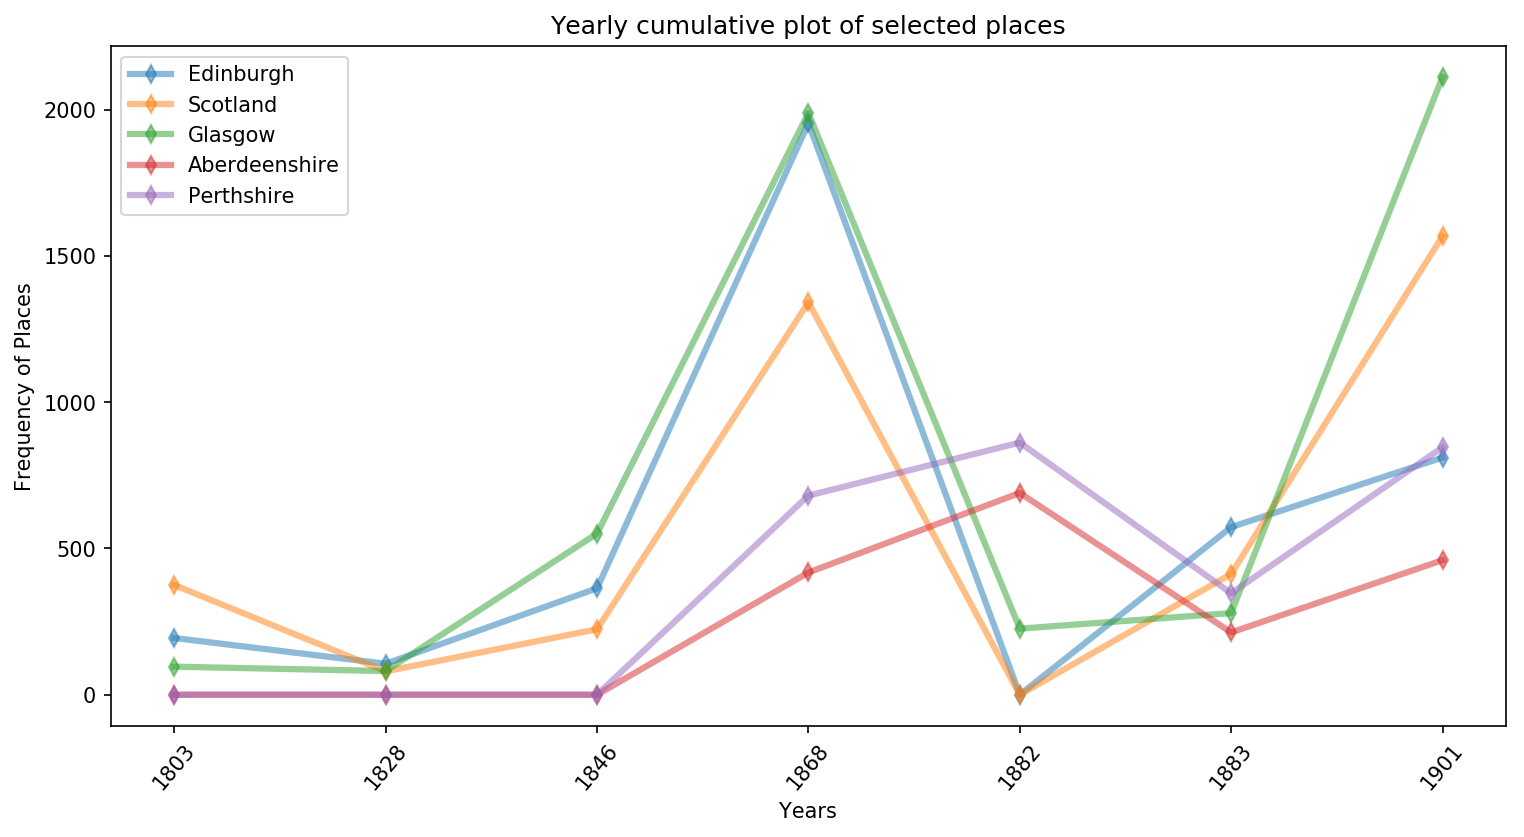

In [30]:
#df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']
mpl.rcParams['figure.dpi']=150
list_places=["Edinburgh", "Scotland", "Glasgow", "Aberdeenshire", "Perthshire"]
cumulative_plot(df_group_places_years, list_places, sorted(years_list))